<h2 style="text-align: center;">Job Application Status Classifier</h2>


### Config

#### Import statements

In [2]:
import pandas as pd
import string
import re
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
import nltk
from nltk.corpus import stopwords
import plotly.graph_objects as go
import spacy
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
import collections
import nlpaug.augmenter.word as naw
from typing import List
from nlpaug.util.file.download import DownloadUtil
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os


2024-11-27 17:39:41.794746: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 17:39:41.805023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732750781.817008  750344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732750781.820436  750344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 17:39:41.833696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

#### Download spacy pipeline **en_core_web_md** for english

In [3]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 41.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


#### Load necessary models

In [4]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
pd.set_option('display.max_colwidth', None)
spacy_model = spacy.load("en_core_web_md")
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")
ner = pipeline("ner", model=model, tokenizer=tokenizer)
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='../model')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/csgrads/mushf001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/csgrads/mushf001/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeq

### Read dataset

#### Read my personal emails. (Downloaded using GMAIL API and labeled manually)

In [5]:
# Read the dataset
SRC = '../data/job_application_emails-v2.csv'
df = pd.read_csv(SRC)
df.columns = df.columns.str.lower()
df.head()

,id,text,label1,label2,from
0,1931c0fd0aba6dd7,"Hi Samiul,\n\nThank you for your interest in our Summer 2025 Internship program\n\nUnfortunately, we have decided to move forward with other candidates.\n\nTo be clear, this has no bearing on future applications here and we invite you to apply again in the future.\n\nThank you again for your interest in PDT Partners.\n\nBest,\n\nPDT Talent & Culture Team",Rejection,Generic,no-reply@pdtpartners.com
1,1931726956eba16f,"Hi Samiul,\n\nThank you for your interest in a role at Twilio! We just received your application.\n\nWe know that job hunting can be stressful. Our intention is to be transparent about our hiring process to help you succeed. On that note, let's talk a bit about our hiring process.\n\nReviewing Your Application\n\nRather than relying on bots and algorithms, Twilio has human recruiters reviewing every application, so it can take a little longer than automated screening. Also, there are no loose ends with us: we'll let you know where you stand either way.\n\nOur Interview Process\n\nIf we like what we see, a recruiting team member will reach out to discuss the opportunity. The next steps could include a few rounds of interviews taking from 2-4 weeks, sometimes longer. While this email doesn't guarantee an interview, we encourage you to check out our Interview Prep Guide ( https://drive.google.com/file/d/15uGbg6AfEbBPt5keqi0NW2ezBPWjaBAD/view ).\n\nEven if you don't move forward with us, it's got some great tips for active job seekers. And to get a feel for the Twilio experience, check out our culture page ( https://www.twilio.com/company/culture ) and follow our LinkedIn ( https://www.linkedin.com/company/twilio-inc-/ ).\n\nThanks again for your interest in building the future of communications!\n\nThank you,\n\n-Twilio Recruiting Team\n\n#WeBuildAtTwilio\n\n( https://www.instagram.com/webuildattwilio/ )\n\n( https://twitter.com/webuildattwilio?lang=en )\n\n( https://www.linkedin.com/company/twilio-inc-/ )",Application Received,NaN,no-reply@twilio.com
2,1931540a2ce12bd4,"\n\n\n\nHi Samiul, Thank you for your interest in the Software Engineering LMTS\n role at Salesforce.Your time and effort are greatly appreciated. Unfortunately, we are no longer hiring\n for this position. Thank you for considering Salesforce in your job search. We will\n keep your resume on file and consider you for other positions that match your skills.With gratitude,The Salesforce Recruiting TeamP.S. This is an auto-generated message. Please do not reply to this email.Subject: Samiul Mushfik ‎- JR269090 Software Engineering LMTS (CA7813597)Click here to view the notification details.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThis email was intended for mushf001@d.umn.edu\n\n\n\n\nsalesforce.com inc. · Salesforce Tower, 415 Mission Street, 3rd Floor, San Francisco, CA 94105\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n",Rejection,No longer accepting,"""workday-support@salesforce.com"" <salesforce@myworkday.com>"
3,1930d4fa93d81e44,"4dE8b1Jx5k2yU7sM3n9TqC6LzV4wP0rA8g5QX\n\nHi Samiul,\n\nThank you so much for your interest in internship opportunities with Snowflake and completing the HackerRank coding challenge. After reviewing your score and background/skillset for a potential fit, we have unfortunately decided not to proceed with your candidacy for the Software Engineer Intern (Infrastructure Automation) - Spring 2025 opening this time around.\n\nBut nothing is forever! We strongly encourage you to reapply for upcoming seasons that are a fit with your background and schedule. We look forward to connecting again.\n\nSpeaking of connecting, we’d like to encourage you to follow Snowflake on https://www.linkedin.com/company/snowflake-computing/ and https://instagram.com/_snowflake_inc?igshid=YmMyMTA2M2Y= They’re both great places to keep up with all things Snowflake.\n\nThanks again for your interest in Snowflake and we hope to see you again in the future!\n\nRegards,\nThe University Recrui

#### Read GPT generated INTERVIEW emails (Generated using some collected email template from INDEED)

In [6]:
GPT_INTERVIEW_DATA_SRC = '../data/all_styles_interview_emails.csv'
gpt_interview_df = pd.read_csv(GPT_INTERVIEW_DATA_SRC)
gpt_interview_df.head()

,Body,Label1,Label2,Author
0,"Hello John Doe,\n\nOur team at AlgoEdge is thrilled to move forward with your application for the Software Engineer role. We’d like to schedule a virtual technical interview with Tina Wilson. It will be conducted via Zoom and last 1 hour.\n\nAvailable time slots:\n\nMonday, Jan 15 – 10 AM, PST\nFriday, Jan 19 – 3 PM, PST\n\nPlease let us know which works for you.",Interview,Technical/Virtual,Person 1
1,"Hi John Doe,\n\nThank you for showing interest in the Software Engineer position at PrimeStack. We’d like to have a brief phone screen with Hannah Hill, our recruiter. Here are the available slots:\n\nMonday, Jan 22 – 10 AM, PST\nFriday, Jan 19 – 3 PM, PST\n\nPlease let us know which time works for you!",Interview,HR/Phone screen,Person 1
2,"Hi John Doe,\n\nWe are excited to invite you to our office for an onsite interview for the Full-Stack Developer position at ByteLogic. During this visit, you’ll meet Rachel Hall and other members of the team.\n\nAvailable times:\n\nTuesday, Jan 16 – 2 PM, EST\nMonday, Jan 22 – 10 AM, PST\n\nPlease let us know which option works for you. Looking forward to meeting you in person!",Interview,Onsite,Person 1
3,"Hello John Doe,\n\nWe’d like to schedule a system design interview for the Backend Developer role at ByteLogic. You’ll collaborate with Ethan White on real-world problems during this session, which will take about 1 hour.\n\nHere are some time slots:\n\nWednesday, Jan 17 – 11 AM, CST\nWednesday, Jan 24 – 11 AM, CST\n\nPlease confirm your availability.",Interview,System Design,Person 1
4,"Hello John Doe,\n\nOur team at NeuraLogic is thrilled to move forward with your application for the Software Engineer role. We’d like to schedule a virtual technical interview with Ethan White. It will be conducted via Zoom and last 1 hour.\n\nAvailable time slots:\n\nWednesday, Jan 17 – 11 AM, CST\nSaturday, Jan 20 – 9 AM, EST\n\nPlease let us know which works for you.",Interview,Technical/Virtual,Person 2


#### Read GPT generated OFFER emails

In [7]:
GPT_OFFER_DATA_SRC = '../data/offer_emails_john_doe_with_labels.csv'
gpt_offer_df = pd.read_csv(GPT_OFFER_DATA_SRC)
gpt_offer_df.head()

,Body,Label2,Author,Label1
0,"Dear John Doe,\n\nWe are delighted to extend an offer for the Marketing Manager position at Company ABC. Your starting salary will be $105,000, and your start date is set for March 12, 2021. Attached are the details of your role and benefits. Kindly reply by June 25, 2021 to confirm your acceptance.\n\nSincerely,\nJohn Smith",Initial,Person 1,Offer
1,"Hi John Doe,\n\nI’m thrilled to offer you the Graphic Designer position at SoftPioneer. Based on your qualifications, we are confident in your ability to excel in this role. Your starting salary is $60,000, and your first day will be July 1, 2021. Please confirm your acceptance by April 10, 2021.\n\nBest regards,\nKaren Walker",Initial,Person 2,Offer
2,"Hello John Doe,\n\nIt’s a pleasure to offer you the position of Graphic Designer at InnovateX. Your annual starting salary is $95,000, and your start date will be March 12, 2021. Please find the job and benefits details attached. Kindly confirm by April 10, 2021.\n\nSincerely,\nKaren Walker",Initial,Person 3,Offer
3,"Hi John Doe,\n\nI’m thrilled to offer you the Graphic Designer position at TechCorp. Based on your qualifications, we are confident in your ability to excel in this role. Your starting salary is $95,000, and your first day will be April 5, 2021. Please confirm your acceptance by March 2, 2021.\n\nBest regards,\nKaren Walker",Initial,Person 4,Offer
4,"Hi John Doe,\n\nCongratulations! We are thrilled to offer you the role of Software Engineer at TechCorp. The position offers an annual starting salary of $85,000, with a start date of June 15, 2021. We are excited to see how you will contribute to our team. Please review the attached details and let us know your decision by June 25, 2021. Feel free to reach out with any questions.\n\nWarm regards,\nLisa Adams",Initial,Person 5,Offer


#### Read GPT generated REJECTION emails

In [8]:
GPT_REJECTION_DATA_SRC = '../data/filtered_rejection_emails.csv'
gpt_rejection_df = pd.read_csv(GPT_REJECTION_DATA_SRC)
gpt_rejection_df.head()

,Body,Label1,Label2
0,"Hi John,\n\nThank you for taking the time to apply for the Software Engineer role at Google. After careful consideration, we regret to inform you that we are no longer reviewing applications for this position. However, we encourage you to explore other opportunities on our careers page that might align with your skills and aspirations.\n\nWe truly appreciate your interest in being a part of Google and wish you success in your job search.\n\nWarm regards,\nGoogle Talent Acquisition",Rejection,No longer accepting
1,"Hello John,\n\nWe sincerely appreciate the effort you put into applying for the Data Scientist Intern position at Meta. Unfortunately, we are no longer accepting applications for this role as it has been filled.\n\nWe value your interest in Meta and encourage you to check back for future openings that suit your profile. Thank you again for considering Meta as a place to grow your career.\n\nBest regards,\nMeta Recruiting Team",Rejection,No longer accepting
2,"Dear John,\n\nThank you for your application for the Junior Developer role at Amazon. At this time, we are no longer reviewing candidates for this specific position.\n\nWe encourage you to explore other roles on our website that match your qualifications. We appreciate your interest in Amazon and wish you the best in your job search.\n\nSincerely,\nAmazon Recruitment Team",Rejection,No longer accepting
3,"Dear John,\n\nThank you for your application to the Software Development Intern position at Netflix. We have had an overwhelming number of talented applicants and have now filled this role. We encourage you to check our careers page regularly for new opportunities that align with your skills.\n\nBest regards,\nNetflix Recruitment Team",Rejection,Position Filled
4,"Hello John,\n\nWe appreciate your interest in the Product Manager Intern role at Adobe. Unfortunately, this position has been filled. However, we encourage you to explore other opportunities on our careers page and apply for positions that match your aspirations.\n\nThank you and best wishes,\nAdobe Talent Team",Rejection,Position Filled


#### Read my personal non-job related emails

In [9]:
NON_JOB_EMAIL_SRC = '../data/non_job_application_emails.csv'
non_job_emails_df = pd.read_csv(NON_JOB_EMAIL_SRC)
non_job_emails_df.head()

,ID,Text,Label,From
0,1935119e1c6ff289,"GQR Global Markets is hiring ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿JobsYour job listings for November 21, 2024Software EngineerNew York, NY\r\n\r\nCapital One3.8 ★Lead Software Engineer, Full StackNew York, NYRDBMSAzureGoManagement\r\n\r\nGQR Global Markets3.0 ★Software Engineer, EquitiesNew York, NY$200K (Employer est.)PermanentMid-level\r\n\r\nHireIdealFounding Software EngineerUnited States$120K - $180K (Employer est.)Easy Apply\r\n\r\nPeloton Interactive3.4 ★Sr. Software Engineer, Full StackNew York, NY$168K - $227K (Employer est.)Easy ApplySpring BootKotlinCloud infrastructureReact\r\n\r\nGQR Global Markets3.0 ★Software Engineer, EquitiesNew York, NY$200K (Employer est.)PermanentMid-level\r\n\r\nMcKinsey & Company4.1 ★Software EngineerNew York, NY$74K - $122K (Employer est.)Software troubleshootingAD&D insuranceData structuresC#\r\n\r\nLS Power3.8 ★Software DeveloperNew York, NY$110K - $125K (Employer est.)Computer sciencePower BIMicrosoft ExcelComputer Science\r\n\r\nAmazon3.6 ★Software Development Engineer II, Employee Engagement ServicesNew York, NY$129K - $224K (Employer est.)Computer scienceComputer ScienceReactFull-stack development\r\n\r\nGoogle4.3 ★Staff Software Engineer, Performance, CoreNew York, NYDoctoral degreeEngineeringData structuresData analysis skills\r\n\r\nJPMorganChase4.0 ★Software EngineerNew York, NY$150K - $185K (Employer est.)JiraCI/CDCommission payComputer science\r\n\r\nNoodle3.1 ★Software Engineer IIINew York, NY$100K - $115K (Employer est.)CI/CDCommuter assistancePaid parental leaveRelational databases\r\n\r\nMorgan Stanley3.9 ★Associate, DeveloperNew York, NY$124K - $150K (Employer est.)Commission payComputer ScienceVisual BasicDB2\r\n\r\nMotor GodsShopify DeveloperNew York, NY$65 - $70 (Employer est.)Easy ApplySee more jobsWant more listings like these?Similar jobs can have different titles.Create job alerts for related roles..net developerCreatefirmware engineerCreatemobile engineerCreateLooking for something a little different?You can edit your job alert here.Software EngineerNew York, NYSent DailyEditThis message was sent to mushf001@d.umn.eduPrivacy Policy | Manage Settings | Unsubscribe Glassdoor2261 Market Street STE 10389, San Francisco, CA 94114 Copyright © 2008-2024, Glassdoor LLC. “Glassdoor,” “Worklife Pro,” “Bowls,” and logo are proprietary trademarks of Glassdoor LLC.\r\n",Not A Job,Glassdoor Jobs <noreply@glassdoor.com>
1,19350e51370b68a4,"Ok, Dr. Teami.\r\n\r\nOn Thu, Nov 21, 2024, 2:58 PM Temitope Olorunfemi \r\nwrote:\r\n\r\n> No, I told them the remaining presentations will be after Thanksgiving.\r\n>\r\n> On Thu, Nov 21, 2024 at 2:56 PM Samiul Mushfik wrote:\r\n>\r\n>> Hello Dr. Temi,\r\n>>\r\n>> Will students need to present anything tomorrow for their project?\r\n>>\r\n>> Sincerely,\r\n>> Samiul Mushfik\r\n>>\r\n>\r\n>\r\n> --\r\n>\r\n> Temitope OLORUNFEMI, Ph.D. (She/her/hers)\r\n>\r\n> Assistant Professor\r\n> Department of Computer Science\r\n>\r\n> University of Minnesota Duluth\r\n>\r\n> *tolorunf@d.umn.edu* |218-726-7194\r\n>\r\n",Not A Job,Samiul Mushfik <mushf001@d.umn.edu>
2,19350de1b1d97789,"\r\n \r\n \r\n\r\n \r\n\r\nhtt

### Pre-processing and Explore data

In [10]:
def convert_to_lowercase(text: str) -> str:
    return text.lower()

def remove_line_breaks(text: str) -> str:
    return re.sub(r"\s+", " ", text.strip())

def remove_punctuation(text: str) -> str:
    return text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

def remove_nontext(text: str) -> str:
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

def extract_main_body(text: str) -> str:
    start_words = ["Samiul Mushfik", "John Doe", "Samiul", "John"]
    normal_end_words = [
        "Thank you", "Best", "Sincerely", "Best Regards", 
        "With gratitude", "Thanks", "Regards", "Cheers", 
        "Thanks again", "Respectfully", 
        "All the best", 
        "Best wishes",
        "Kind regards", "Good luck", "Take care,", 
        "Thank you once again", "Wish you all the best"
         
    ]
    special_end_words = ["connect soon", "The Redfin Recruiting Team", "In the meantime", "\\*\\*",
                         "consideration", "Thanks again for your interest", "Shipt",  "We wish you success", 
                         "Speaking of connecting", "Sent from"]

    start_pattern = r"(?:" + "|".join(re.escape(word) + r"[,\s]*" for word in start_words) + r")"
    normal_end_pattern = r"(?:" + "|".join(re.escape(word) for word in normal_end_words) + r")"
    special_end_pattern = r"(?:" + "|".join(re.escape(word) for word in special_end_words) + r")"

    starts = list(re.finditer(start_pattern, text, re.IGNORECASE))
    normal_ends = list(re.finditer(normal_end_pattern, text, re.IGNORECASE))
    special_ends = list(re.finditer(special_end_pattern, text, re.IGNORECASE))

    if not starts:
        if normal_ends:
            for end in normal_ends:
                if end.start() <= 50:
                    continue
                return text[:end.start()].strip()
        if special_ends:
            for end in special_ends:
                if end.start() <= 50:
                    continue
                return text[:end.start()].strip()
        return text
    
    normal_valid_pairs = []
    special_valid_pairs = []
    for start in starts:
        for end in normal_ends:
            if end.start() > start.end() + 1:
                normal_valid_pairs.append((start, end))
                
        for end in special_ends:
            if end.start() > start.end() + 1:
                special_valid_pairs.append((start, end))
    

    if not normal_valid_pairs and not special_valid_pairs:
        return text[starts[0].end():]
    
    best_pair = None
    if normal_valid_pairs:
        best_pair = max(normal_valid_pairs, key=lambda pair: pair[1].start() - pair[0].end())
    else:
        best_pair = max(special_valid_pairs, key=lambda pair: pair[1].start() - pair[0].end())

    start, end = best_pair
    between_text = text[start.end():end.start()].strip()
    return between_text


def prepend(text: str) -> str:
    start_phrases = ["Samiul", "Samiul Mushfik"]
    pattern = r"(?:{})".format("|".join(re.escape(phrase) for phrase in start_phrases))
    return "Samiul, " + text if not re.search(pattern, text, re.IGNORECASE) else text

    
def remove_links(text: str) -> str:
    pattern = r'\(?https?://[^\s)]+\)?'
    return re.sub(pattern, '', text)

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_company_names(text: str) -> str:
    company_names = ['roblox', 'salesforce', 'adobe', 'redfin']
    results = ner(text)
    res = text
    
    for i in range(len(results)):
        if results[i]['entity'] in ['B-ORG', 'I-ORG']:
            if i == 0:
                res = text[:results[i]['start']]
            else:
                res += text[results[i-1]['end'] + 1:results[i]['start']]
        else:
            if i == 0:
                res = text[:results[i]['end'] + 1]
            else:
                res += text[results[i-1]['end'] + 1:results[i]['end'] + 1]

    if results:
        res += text[results[-1]['end'] + 1:]
    
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in company_names) + r')\b'
    return re.sub(pattern, '', res, flags=re.IGNORECASE).strip()

def remove_datetime(text: str) -> str:
    doc = spacy_model(text)
    date_time_entities = [ent.text for ent in doc.ents if ent.label_ in ["DATE", "TIME"]]
    for entity in date_time_entities:
        text = re.sub(entity, '', text, flags=re.IGNORECASE)
    date_time_pattern = r'\b(?:\d{4}[-/]\d{1,2}[-/]\d{1,2}|\d{1,2}[-/]\d{1,2}[-/]\d{4}|[A-Za-z]+ \d{1,2}, \d{4})\b|\b\d{1,2}:\d{2}(?::\d{2})?(?: ?[APap][Mm])?\b'
    return re.sub(date_time_pattern, '', text, flags=re.IGNORECASE)


def tokenize_and_lemmatize(text: str) -> str:
    doc = spacy_model(text)
    return " ".join([token.lemma_ for token in doc])
    

def remove_short_words(text: str, min_length: int = 2) -> str:
    return " ".join(word for word in text.split() if len(word) > min_length)

def remove_email(text: str) -> str:
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    return re.sub(email_pattern, '', text, flags=re.IGNORECASE)

def remove_person_names(text: str) -> str:
    
    results = ner(text)
    words = []
    for i in range(len(results)):
        if results[i]['entity'] == 'B-PER':
            words.append(results[i]['word'])
            j = i + 1
            while j < len(results) and results[j]['entity'] == 'I-PER':
                words.append(results[j]['word'])
                j += 1
            break
        
    if words:
        person = ".?".join(words).replace('##', '')
        return re.sub(person, '', text, flags=re.IGNORECASE)
    return text

def remove_special_words(text: str) -> str:
    words_to_remove = ["full stack developer intern", "googler", "swe", "site reliability engineering", 
                       "program", "internship", "software", "engineering", "lmts", "role",
                       "engineer", "backend", "team", "position", "engineering", 'platform', 'remote']
    
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE).strip()
    

def protect_company_names(text: str) -> str:
    entities = ner(text)
    for entity in entities:
        if entity['entity'] in ['B-ORG', 'I-ORG']:
            text = text.replace(entity['word'], '[ORG]')
    return text

def protect_person_names(text: str) -> str:
    entities = ner(text)
    for entity in entities:
        if entity['entity'] in ['B-PER', 'I-PER']:
            text = text.replace(entity['word'], '[PER]')
    return text


In [11]:
def plot_word_cloud(text: str, title: str):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=200
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [12]:
def process_gpt_generated_data(df: pd.DataFrame) -> pd.DataFrame:
    if 'Author' in df.columns:  
        df.drop(columns=['Author'], inplace=True)
    df.columns = df.columns.str.lower()
    df.rename(columns={'body': 'text'}, inplace=True)
    df.head()
    return df
    
gpt_interview_df = process_gpt_generated_data(gpt_interview_df)
gpt_offer_df = process_gpt_generated_data(gpt_offer_df)
gpt_rejection_df = process_gpt_generated_data(gpt_rejection_df)

In [166]:

def plot_value_counts(df, column_name, title="Value Counts", xaxis_title="Category", yaxis_title="Count"):
    """
    Plot the value counts of a column in a pandas DataFrame using Plotly.

    Parameters:
    - df: pandas.DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column to compute value counts for.
    - title: str, optional
        The title of the plot (default is "Value Counts").
    - xaxis_title: str, optional
        Title for the x-axis (default is "Category").
    - yaxis_title: str, optional
        Title for the y-axis (default is "Count").
    """
    value_counts = df[column_name].value_counts().reset_index()
    value_counts.columns = [column_name, 'Count']

    fig = px.bar(value_counts, x=column_name, y='Count', title=title, text='Count', color=column_name, color_discrete_sequence=px.colors.qualitative.Plotly)
    fig.update_traces(textposition='outside')
    fig.update_layout(xaxis_title=xaxis_title, yaxis_title=yaxis_title, height=500, width=700)

    fig.show()

In [168]:
print(gpt_interview_df['label1'].value_counts())
print(gpt_interview_df['label2'].value_counts())
print(gpt_offer_df['label1'].value_counts())
print(gpt_offer_df['label2'].value_counts())
print(gpt_rejection_df['label1'].value_counts())
print(gpt_rejection_df['label2'].value_counts())

label1
Interview    40
Name: count, dtype: int64
label2
Technical/Virtual    10
HR/Phone screen      10
Onsite               10
System Design        10
Name: count, dtype: int64
label1
Offer    30
Name: count, dtype: int64
label2
Initial        10
Negotiation    10
Final          10
Name: count, dtype: int64
label1
Rejection    9
Name: count, dtype: int64
label2
Position Filled        6
No longer accepting    3
Name: count, dtype: int64


#### Process non-job related email dataframe (Rename, Remove columns as needed)

In [169]:
non_job_emails_df.columns = non_job_emails_df.columns.str.lower()
non_job_emails_df.rename(columns={'label': 'label1'}, inplace=True)
non_job_emails_df['label2'] = ''
columns_to_drop = ['id', 'from']
columns_present = [col for col in columns_to_drop if col in non_job_emails_df.columns]
if columns_present:
    non_job_emails_df.drop(columns=columns_present, inplace=True)
non_job_emails_df.head()

,text,label1,label2
0,"GQR Global Markets is hiring ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿JobsYour job listings for November 21, 2024Software EngineerNew York, NY\r\n\r\nCapital One3.8 ★Lead Software Engineer, Full StackNew York, NYRDBMSAzureGoManagement\r\n\r\nGQR Global Markets3.0 ★Software Engineer, EquitiesNew York, NY$200K (Employer est.)PermanentMid-level\r\n\r\nHireIdealFounding Software EngineerUnited States$120K - $180K (Employer est.)Easy Apply\r\n\r\nPeloton Interactive3.4 ★Sr. Software Engineer, Full StackNew York, NY$168K - $227K (Employer est.)Easy ApplySpring BootKotlinCloud infrastructureReact\r\n\r\nGQR Global Markets3.0 ★Software Engineer, EquitiesNew York, NY$200K (Employer est.)PermanentMid-level\r\n\r\nMcKinsey & Company4.1 ★Software EngineerNew York, NY$74K - $122K (Employer est.)Software troubleshootingAD&D insuranceData structuresC#\r\n\r\nLS Power3.8 ★Software DeveloperNew York, NY$110K - $125K (Employer est.)Computer sciencePower BIMicrosoft ExcelComputer Science\r\n\r\nAmazon3.6 ★Software Development Engineer II, Employee Engagement ServicesNew York, NY$129K - $224K (Employer est.)Computer scienceComputer ScienceReactFull-stack development\r\n\r\nGoogle4.3 ★Staff Software Engineer, Performance, CoreNew York, NYDoctoral degreeEngineeringData structuresData analysis skills\r\n\r\nJPMorganChase4.0 ★Software EngineerNew York, NY$150K - $185K (Employer est.)JiraCI/CDCommission payComputer science\r\n\r\nNoodle3.1 ★Software Engineer IIINew York, NY$100K - $115K (Employer est.)CI/CDCommuter assistancePaid parental leaveRelational databases\r\n\r\nMorgan Stanley3.9 ★Associate, DeveloperNew York, NY$124K - $150K (Employer est.)Commission payComputer ScienceVisual BasicDB2\r\n\r\nMotor GodsShopify DeveloperNew York, NY$65 - $70 (Employer est.)Easy ApplySee more jobsWant more listings like these?Similar jobs can have different titles.Create job alerts for related roles..net developerCreatefirmware engineerCreatemobile engineerCreateLooking for something a little different?You can edit your job alert here.Software EngineerNew York, NYSent DailyEditThis message was sent to mushf001@d.umn.eduPrivacy Policy | Manage Settings | Unsubscribe Glassdoor2261 Market Street STE 10389, San Francisco, CA 94114 Copyright © 2008-2024, Glassdoor LLC. “Glassdoor,” “Worklife Pro,” “Bowls,” and logo are proprietary trademarks of Glassdoor LLC.\r\n",Not A Job,
1,"Ok, Dr. Teami.\r\n\r\nOn Thu, Nov 21, 2024, 2:58 PM Temitope Olorunfemi \r\nwrote:\r\n\r\n> No, I told them the remaining presentations will be after Thanksgiving.\r\n>\r\n> On Thu, Nov 21, 2024 at 2:56 PM Samiul Mushfik wrote:\r\n>\r\n>> Hello Dr. Temi,\r\n>>\r\n>> Will students need to present anything tomorrow for their project?\r\n>>\r\n>> Sincerely,\r\n>> Samiul Mushfik\r\n>>\r\n>\r\n>\r\n> --\r\n>\r\n> Temitope OLORUNFEMI, Ph.D. (She/her/hers)\r\n>\r\n> Assistant Professor\r\n> Department of Computer Science\r\n>\r\n> University of Minnesota Duluth\r\n>\r\n> *tolorunf@d.umn.edu* |218-726-7194\r\n>\r\n",Not A Job,
2,"\r\n \r\n \r\n\r\n \r\n\r\nhttps://view.ecommunications2.umn.edu/?qs=0f65c08a2ec3d8affdcba2f55d37cf1095d776607632461fe378a5f046b66bbf252a253bf31598f1bb3ac

#### Process original email dataframe (Rename, Remove columns as needed)

In [170]:
temp_df = df.drop(columns=['id', 'from'])
temp_df = temp_df.dropna(subset=['label1'])
temp_df = temp_df.fillna({'label2': ''})
temp_df.head()

,text,label1,label2
0,"Hi Samiul,\n\nThank you for your interest in our Summer 2025 Internship program\n\nUnfortunately, we have decided to move forward with other candidates.\n\nTo be clear, this has no bearing on future applications here and we invite you to apply again in the future.\n\nThank you again for your interest in PDT Partners.\n\nBest,\n\nPDT Talent & Culture Team",Rejection,Generic
1,"Hi Samiul,\n\nThank you for your interest in a role at Twilio! We just received your application.\n\nWe know that job hunting can be stressful. Our intention is to be transparent about our hiring process to help you succeed. On that note, let's talk a bit about our hiring process.\n\nReviewing Your Application\n\nRather than relying on bots and algorithms, Twilio has human recruiters reviewing every application, so it can take a little longer than automated screening. Also, there are no loose ends with us: we'll let you know where you stand either way.\n\nOur Interview Process\n\nIf we like what we see, a recruiting team member will reach out to discuss the opportunity. The next steps could include a few rounds of interviews taking from 2-4 weeks, sometimes longer. While this email doesn't guarantee an interview, we encourage you to check out our Interview Prep Guide ( https://drive.google.com/file/d/15uGbg6AfEbBPt5keqi0NW2ezBPWjaBAD/view ).\n\nEven if you don't move forward with us, it's got some great tips for active job seekers. And to get a feel for the Twilio experience, check out our culture page ( https://www.twilio.com/company/culture ) and follow our LinkedIn ( https://www.linkedin.com/company/twilio-inc-/ ).\n\nThanks again for your interest in building the future of communications!\n\nThank you,\n\n-Twilio Recruiting Team\n\n#WeBuildAtTwilio\n\n( https://www.instagram.com/webuildattwilio/ )\n\n( https://twitter.com/webuildattwilio?lang=en )\n\n( https://www.linkedin.com/company/twilio-inc-/ )",Application Received,
2,"\n\n\n\nHi Samiul, Thank you for your interest in the Software Engineering LMTS\n role at Salesforce.Your time and effort are greatly appreciated. Unfortunately, we are no longer hiring\n for this position. Thank you for considering Salesforce in your job search. We will\n keep your resume on file and consider you for other positions that match your skills.With gratitude,The Salesforce Recruiting TeamP.S. This is an auto-generated message. Please do not reply to this email.Subject: Samiul Mushfik ‎- JR269090 Software Engineering LMTS (CA7813597)Click here to view the notification details.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThis email was intended for mushf001@d.umn.edu\n\n\n\n\nsalesforce.com inc. · Salesforce Tower, 415 Mission Street, 3rd Floor, San Francisco, CA 94105\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n",Rejection,No longer accepting
3,"4dE8b1Jx5k2yU7sM3n9TqC6LzV4wP0rA8g5QX\n\nHi Samiul,\n\nThank you so much for your interest in internship opportunities with Snowflake and completing the HackerRank coding challenge. After reviewing your score and background/skillset for a potential fit, we have unfortunately decided not to proceed with your candidacy for the Software Engineer Intern (Infrastructure Automation) - Spring 2025 opening this time around.\n\nBut nothing is forever! We strongly encourage you to reapply for upcoming seasons that are a fit with your background and schedule. We look forward to connecting again.\n\nSpeaking of connecting, we’d like to encourage you to follow Snowflake on https://www.linkedin.com/company/snowflake-computing/ and https://instagram.com/_snowflake_inc?igshid=YmMyMTA2M2Y= They’re both great places to keep up with all things Snowflake.\n\nThanks again for your interest in Snowflake and we hope to see you again in the future!\n\nRegards,\nThe University Recruiting Team\n\nf2Yt9J4eK8mW6pL1nQ3dV7uX0rC5zA9B6sTgP",Rejection,Generic
4,"DoorDash Logo\nHi Samiul,\n\nThank you for applying to DoorDash's Software Engineer, Backend (All Teams) position! 

In [171]:
print(temp_df.columns)
print(gpt_interview_df.columns)
print(gpt_offer_df.columns)
print(gpt_rejection_df.columns)
print(non_job_emails_df.columns)

Index(['text', 'label1', 'label2'], dtype='object')
Index(['text', 'label1', 'label2'], dtype='object')
Index(['text', 'label1', 'label2'], dtype='object')
Index(['text', 'label1', 'label2'], dtype='object')
Index(['text', 'label1', 'label2'], dtype='object')


In [172]:
gpt_offer_df = gpt_offer_df[['text', 'label1', 'label2']]
gpt_interview_df = gpt_interview_df[['text', 'label1', 'label2']]
print(gpt_offer_df.columns)
print(gpt_interview_df.columns)

Index(['text', 'label1', 'label2'], dtype='object')
Index(['text', 'label1', 'label2'], dtype='object')


In [173]:
job_email_df = pd.concat([temp_df, gpt_interview_df, gpt_offer_df, gpt_rejection_df], ignore_index=True)
job_email_df.head()

,text,label1,label2
0,"Hi Samiul,\n\nThank you for your interest in our Summer 2025 Internship program\n\nUnfortunately, we have decided to move forward with other candidates.\n\nTo be clear, this has no bearing on future applications here and we invite you to apply again in the future.\n\nThank you again for your interest in PDT Partners.\n\nBest,\n\nPDT Talent & Culture Team",Rejection,Generic
1,"Hi Samiul,\n\nThank you for your interest in a role at Twilio! We just received your application.\n\nWe know that job hunting can be stressful. Our intention is to be transparent about our hiring process to help you succeed. On that note, let's talk a bit about our hiring process.\n\nReviewing Your Application\n\nRather than relying on bots and algorithms, Twilio has human recruiters reviewing every application, so it can take a little longer than automated screening. Also, there are no loose ends with us: we'll let you know where you stand either way.\n\nOur Interview Process\n\nIf we like what we see, a recruiting team member will reach out to discuss the opportunity. The next steps could include a few rounds of interviews taking from 2-4 weeks, sometimes longer. While this email doesn't guarantee an interview, we encourage you to check out our Interview Prep Guide ( https://drive.google.com/file/d/15uGbg6AfEbBPt5keqi0NW2ezBPWjaBAD/view ).\n\nEven if you don't move forward with us, it's got some great tips for active job seekers. And to get a feel for the Twilio experience, check out our culture page ( https://www.twilio.com/company/culture ) and follow our LinkedIn ( https://www.linkedin.com/company/twilio-inc-/ ).\n\nThanks again for your interest in building the future of communications!\n\nThank you,\n\n-Twilio Recruiting Team\n\n#WeBuildAtTwilio\n\n( https://www.instagram.com/webuildattwilio/ )\n\n( https://twitter.com/webuildattwilio?lang=en )\n\n( https://www.linkedin.com/company/twilio-inc-/ )",Application Received,
2,"\n\n\n\nHi Samiul, Thank you for your interest in the Software Engineering LMTS\n role at Salesforce.Your time and effort are greatly appreciated. Unfortunately, we are no longer hiring\n for this position. Thank you for considering Salesforce in your job search. We will\n keep your resume on file and consider you for other positions that match your skills.With gratitude,The Salesforce Recruiting TeamP.S. This is an auto-generated message. Please do not reply to this email.Subject: Samiul Mushfik ‎- JR269090 Software Engineering LMTS (CA7813597)Click here to view the notification details.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThis email was intended for mushf001@d.umn.edu\n\n\n\n\nsalesforce.com inc. · Salesforce Tower, 415 Mission Street, 3rd Floor, San Francisco, CA 94105\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n",Rejection,No longer accepting
3,"4dE8b1Jx5k2yU7sM3n9TqC6LzV4wP0rA8g5QX\n\nHi Samiul,\n\nThank you so much for your interest in internship opportunities with Snowflake and completing the HackerRank coding challenge. After reviewing your score and background/skillset for a potential fit, we have unfortunately decided not to proceed with your candidacy for the Software Engineer Intern (Infrastructure Automation) - Spring 2025 opening this time around.\n\nBut nothing is forever! We strongly encourage you to reapply for upcoming seasons that are a fit with your background and schedule. We look forward to connecting again.\n\nSpeaking of connecting, we’d like to encourage you to follow Snowflake on https://www.linkedin.com/company/snowflake-computing/ and https://instagram.com/_snowflake_inc?igshid=YmMyMTA2M2Y= They’re both great places to keep up with all things Snowflake.\n\nThanks again for your interest in Snowflake and we hope to see you again in the future!\n\nRegards,\nThe University Recruiting Team\n\nf2Yt9J4eK8mW6pL1nQ3dV7uX0rC5zA9B6sTgP",Rejection,Generic
4,"DoorDash Logo\nHi Samiul,\n\nThank you for applying to DoorDash's Software Engineer, Backend (All Teams) position! 

In [179]:
dfs = [temp_df, gpt_interview_df, gpt_offer_df, gpt_rejection_df, non_job_emails_df]
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.head()

,text,label1,label2
0,"Hi Samiul,\n\nThank you for your interest in our Summer 2025 Internship program\n\nUnfortunately, we have decided to move forward with other candidates.\n\nTo be clear, this has no bearing on future applications here and we invite you to apply again in the future.\n\nThank you again for your interest in PDT Partners.\n\nBest,\n\nPDT Talent & Culture Team",Rejection,Generic
1,"Hi Samiul,\n\nThank you for your interest in a role at Twilio! We just received your application.\n\nWe know that job hunting can be stressful. Our intention is to be transparent about our hiring process to help you succeed. On that note, let's talk a bit about our hiring process.\n\nReviewing Your Application\n\nRather than relying on bots and algorithms, Twilio has human recruiters reviewing every application, so it can take a little longer than automated screening. Also, there are no loose ends with us: we'll let you know where you stand either way.\n\nOur Interview Process\n\nIf we like what we see, a recruiting team member will reach out to discuss the opportunity. The next steps could include a few rounds of interviews taking from 2-4 weeks, sometimes longer. While this email doesn't guarantee an interview, we encourage you to check out our Interview Prep Guide ( https://drive.google.com/file/d/15uGbg6AfEbBPt5keqi0NW2ezBPWjaBAD/view ).\n\nEven if you don't move forward with us, it's got some great tips for active job seekers. And to get a feel for the Twilio experience, check out our culture page ( https://www.twilio.com/company/culture ) and follow our LinkedIn ( https://www.linkedin.com/company/twilio-inc-/ ).\n\nThanks again for your interest in building the future of communications!\n\nThank you,\n\n-Twilio Recruiting Team\n\n#WeBuildAtTwilio\n\n( https://www.instagram.com/webuildattwilio/ )\n\n( https://twitter.com/webuildattwilio?lang=en )\n\n( https://www.linkedin.com/company/twilio-inc-/ )",Application Received,
2,"\n\n\n\nHi Samiul, Thank you for your interest in the Software Engineering LMTS\n role at Salesforce.Your time and effort are greatly appreciated. Unfortunately, we are no longer hiring\n for this position. Thank you for considering Salesforce in your job search. We will\n keep your resume on file and consider you for other positions that match your skills.With gratitude,The Salesforce Recruiting TeamP.S. This is an auto-generated message. Please do not reply to this email.Subject: Samiul Mushfik ‎- JR269090 Software Engineering LMTS (CA7813597)Click here to view the notification details.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThis email was intended for mushf001@d.umn.edu\n\n\n\n\nsalesforce.com inc. · Salesforce Tower, 415 Mission Street, 3rd Floor, San Francisco, CA 94105\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n",Rejection,No longer accepting
3,"4dE8b1Jx5k2yU7sM3n9TqC6LzV4wP0rA8g5QX\n\nHi Samiul,\n\nThank you so much for your interest in internship opportunities with Snowflake and completing the HackerRank coding challenge. After reviewing your score and background/skillset for a potential fit, we have unfortunately decided not to proceed with your candidacy for the Software Engineer Intern (Infrastructure Automation) - Spring 2025 opening this time around.\n\nBut nothing is forever! We strongly encourage you to reapply for upcoming seasons that are a fit with your background and schedule. We look forward to connecting again.\n\nSpeaking of connecting, we’d like to encourage you to follow Snowflake on https://www.linkedin.com/company/snowflake-computing/ and https://instagram.com/_snowflake_inc?igshid=YmMyMTA2M2Y= They’re both great places to keep up with all things Snowflake.\n\nThanks again for your interest in Snowflake and we hope to see you again in the future!\n\nRegards,\nThe University Recruiting Team\n\nf2Yt9J4eK8mW6pL1nQ3dV7uX0rC5zA9B6sTgP",Rejection,Generic
4,"DoorDash Logo\nHi Samiul,\n\nThank you for applying to DoorDash's Software Engineer, Backend (All Teams) position! 

In [180]:
merged_df['label1'].value_counts()

label1
Not A Job               400
Application Received    110
Rejection                82
Interview                56
Offer                    30
Assesment Received        2
Name: count, dtype: int64

In [181]:
merged_df['text'].iloc[2]

'\n\n\n\nHi Samiul, Thank you for your interest in the Software Engineering LMTS\n      role at Salesforce.Your time and effort are greatly appreciated. Unfortunately, we are no longer hiring\n      for this position. Thank you for considering Salesforce in your job search. We will\n      keep your resume on file and consider you for other positions that match your skills.With gratitude,The Salesforce Recruiting TeamP.S. This is an auto-generated message. Please do not reply to this email.Subject: Samiul Mushfik \u200e- JR269090 Software Engineering LMTS (CA7813597)Click here to view the notification details.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThis email was intended for mushf001@d.umn.edu\n\n\n\n\nsalesforce.com inc. · Salesforce Tower, 415 Mission Street, 3rd Floor, San Francisco, CA 94105\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [182]:
processed_df = merged_df.copy()
processed_df = processed_df[~processed_df['label1'].isin(['Assesment Received'])]
processed_df.reset_index(inplace=True, drop=True)
processed_df['text'] = processed_df['text'].apply(extract_main_body) \
    .apply(remove_line_breaks) \
        .apply(convert_to_lowercase)
#         .apply(remove_company_names) \
#             .apply(remove_person_names) \
#                 .apply(convert_to_lowercase) \
#                     .apply(remove_datetime) \
#                         .apply(remove_email) \
#                             .apply(remove_links) \
#                                 .apply(remove_nontext) \
#                                     .apply(remove_short_words) \
#                                         .apply(remove_special_words) \
#                                             .apply(tokenize_and_lemmatize)
processed_df.head()

,text,label1,label2
0,"thank you for your interest in our summer 2025 internship program unfortunately, we have decided to move forward with other candidates. to be clear, this has no bearing on future applications here and we invite you to apply again in the future. thank you again for your interest in pdt partners.",Rejection,Generic
1,"thank you for your interest in a role at twilio! we just received your application. we know that job hunting can be stressful. our intention is to be transparent about our hiring process to help you succeed. on that note, let's talk a bit about our hiring process. reviewing your application rather than relying on bots and algorithms, twilio has human recruiters reviewing every application, so it can take a little longer than automated screening. also, there are no loose ends with us: we'll let you know where you stand either way. our interview process if we like what we see, a recruiting team member will reach out to discuss the opportunity. the next steps could include a few rounds of interviews taking from 2-4 weeks, sometimes longer. while this email doesn't guarantee an interview, we encourage you to check out our interview prep guide ( https://drive.google.com/file/d/15ugbg6afebbpt5keqi0nw2ezbpwjabad/view ). even if you don't move forward with us, it's got some great tips for active job seekers. and to get a feel for the twilio experience, check out our culture page ( https://www.twilio.com/company/culture ) and follow our linkedin ( https://www.linkedin.com/company/twilio-inc-/ ). thanks again for your interest in building the future of communications!",Application Received,
2,"thank you for your interest in the software engineering lmts role at salesforce.your time and effort are greatly appreciated. unfortunately, we are no longer hiring for this position. thank you for considering salesforce in your job search. we will keep your resume on file and consider you for other positions that match your skills.",Rejection,No longer accepting
3,"thank you so much for your interest in internship opportunities with snowflake and completing the hackerrank coding challenge. after reviewing your score and background/skillset for a potential fit, we have unfortunately decided not to proceed with your candidacy for the software engineer intern (infrastructure automation) - spring 2025 opening this time around. but nothing is forever! we strongly encourage you to reapply for upcoming seasons that are a fit with your background and schedule. we look forward to connecting again. speaking of connecting, we’d like to encourage you to follow snowflake on https://www.linkedin.com/company/snowflake-computing/ and https://instagram.com/_snowflake_inc?igshid=ymmymta2m2y= they’re both great places to keep up with all things snowflake. thanks again for your interest in snowflake and we hope to see you again in the future!",Rejection,Generic
4,"thank you for applying to doordash's software engineer, backend (all teams) position! we've received your application and will review it as soon as possible! if your background looks like a good match, we'll reach out to coordinate next steps. in the meantime, feel free to download the doordash app and give us a go! you can also check us out / follow us on social media. ( https://www.glassdoor.com/overview/working-at-doordash-ei_ie813073.11,19.htm ) our commitment to diversity and inclusion we’re committed to growing and empowering a more inclusive community within our company, industry, and cities. that’s why we hire and cultivate diverse teams of the",Application Received,


In [183]:
processed_df[processed_df['label1'] == 'Not A Job'].head()

,text,label1,label2
278,"gqr global markets is hiring ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿ ‌​‍‎‏﻿jobsyour job listings for november 21, 2024software engineernew york, ny capital one3.8 ★lead software engineer, full stacknew york, nyrdbmsazuregomanagement gqr global markets3.0 ★software engineer, equitiesnew york, ny$200k (employer est.)permanentmid-level hireidealfounding software engineerunited states$120k - $180k (employer est.)easy apply peloton interactive3.4 ★sr. software engineer, full stacknew york, ny$168k - $227k (employer est.)easy applyspring bootkotlincloud infrastructurereact gqr global markets3.0 ★software engineer, equitiesnew york, ny$200k (employer est.)permanentmid-level mckinsey & company4.1 ★software engineernew york, ny$74k - $122k (employer est.)software troubleshootingad&d insurancedata structuresc# ls power3.8 ★software developernew york, ny$110k - $125k (employer est.)computer sciencepower bimicrosoft excelcomputer science amazon3.6 ★software development engineer ii, employee engagement servicesnew york, ny$129k - $224k (employer est.)computer sciencecomputer sciencereactfull-stack development google4.3 ★staff software engineer, performance, corenew york, nydoctoral degreeengineeringdata structuresdata analysis skills jpmorganchase4.0 ★software engineernew york, ny$150k - $185k (employer est.)jiraci/cdcommission paycomputer science noodle3.1 ★software engineer iiinew york, ny$100k - $115k (employer est.)ci/cdcommuter assistancepaid parental leaverelational databases morgan stanley3.9 ★associate, developernew york, ny$124k - $150k (employer est.)commission paycomputer sciencevisual basicdb2 motor godsshopify developernew york, ny$65 - $70 (employer est.)easy applysee more jobswant more listings like these?similar jobs can have different titles.create job alerts for related roles..net developercreatefirmware engineercreatemobile engineercreatelooking for something a little different?you can edit your job alert here.software engineernew york, nysent dailyeditthis message was sent to mushf001@d.umn.eduprivacy policy | manage settings | unsubscribe glassdoor2261 market street ste 10389, san francisco, ca 94114 copyright © 2008-2024, glassdoor llc. “glassdoor,” “worklife pro,” “bowls,” and logo are proprietary trademarks of glassdoor llc.",Not A Job,
279,"wrote: > >> hello dr. temi, >> >> will students need to present anything tomorrow for their project? >> >>",Not A Job,
280,"https://view.ecommunications2.umn.edu/?qs=0f65c08a2ec3d8affdcba2f55d37cf1095d776607632461fe378a5f046b66bbf252a253bf31598f1bb3ac57fad742c8797bf44e3f477fb609bb7bb76227303987dd645e47adb626d966163328afb74a7 view this message on the web . office for equity & diversity | office of information technology office for digital accessibility dear faculty and instructors, we are writing to inform you of a new legal requirement for all faculty, instructors, and others at the university of minnesota. specifically, by april 2026, university websites, canvas course materials, mobile apps, and other web-based content must meet the standard for accessibility set by the https://click.ecommunications2.umn.edu/?qs=38917c34f038736869c899eb82efd546f3b6970351ea0a750

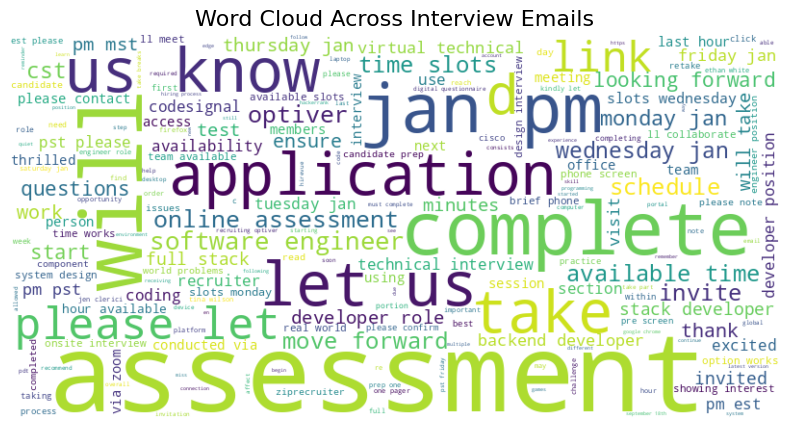

In [185]:
plot_word_cloud(" ".join(processed_df[processed_df['label1'] == 'Interview']['text']), title='Word Cloud Across Interview Emails')

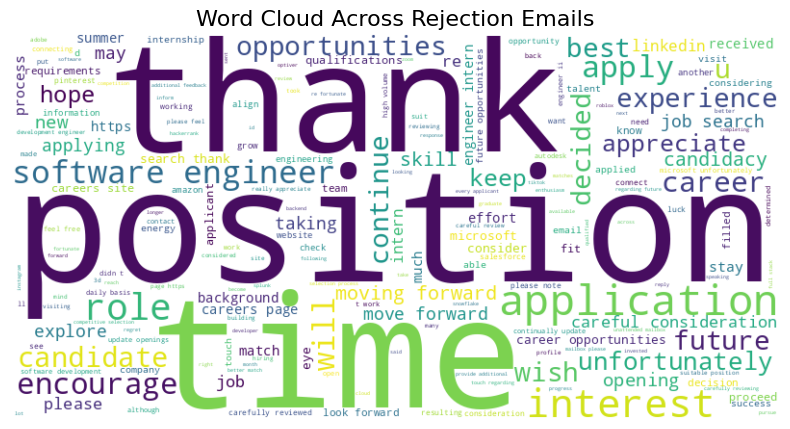

In [186]:
plot_word_cloud(" ".join(processed_df[processed_df['label1'] == 'Rejection']['text']), title='Word Cloud Across Rejection Emails')

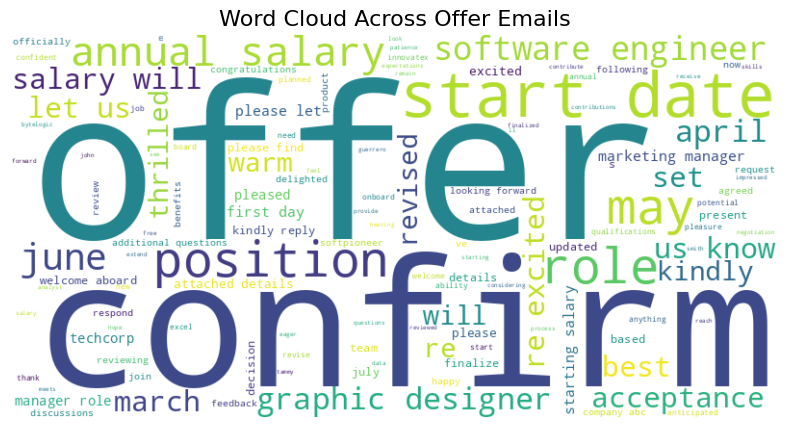

In [187]:
plot_word_cloud(" ".join(processed_df[processed_df['label1'] == 'Offer']['text']), title='Word Cloud Across Offer Emails')

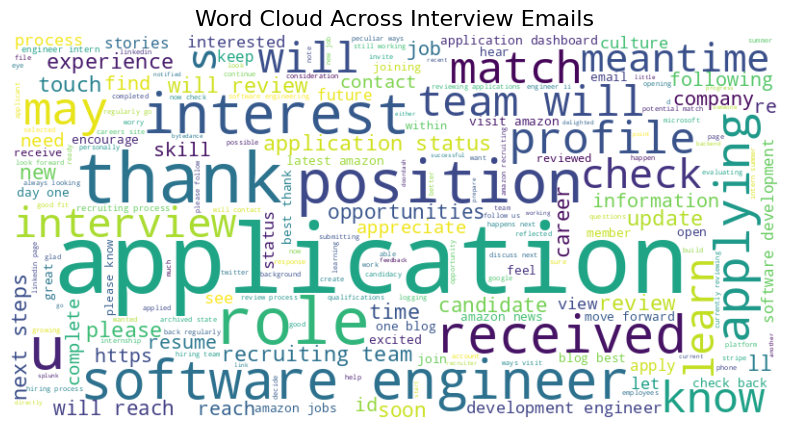

In [189]:
plot_word_cloud(" ".join(processed_df[processed_df['label1'] == 'Application Received']['text']), title='Word Cloud Across Interview Emails')

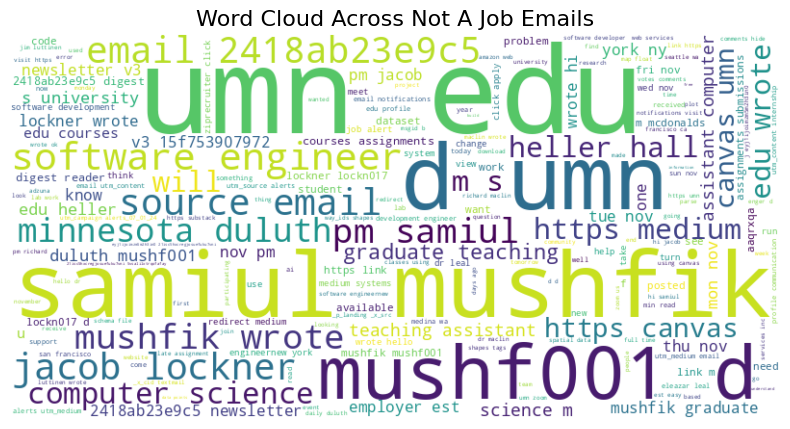

In [190]:
plot_word_cloud(" ".join(processed_df[processed_df['label1'] == 'Not A Job']['text']), title='Word Cloud Across Not A Job Emails')

Not a Job emails need to be further processed.

In [194]:
df_for_label_distribution = processed_df.copy()
df_for_label_distribution['label2'] = df_for_label_distribution['label2'].replace('', np.nan)  # Replace empty strings with NaN
df_for_label_distribution['label2'] = df_for_label_distribution['label2'].fillna(df_for_label_distribution['label1'])  # Fill NaN values with corresponding Column1 values

In [195]:
df_for_label_distribution['label1'].value_counts()

label1
Not A Job               400
Application Received    110
Rejection                82
Interview                56
Offer                    30
Name: count, dtype: int64

In [196]:
df_for_label_distribution['label2'].value_counts()

label2
Not A Job               400
Application Received    110
Generic                  62
Online Assessment        15
Position Filled          10
No longer accepting      10
System Design            10
Technical/Virtual        10
Onsite                   10
HR/Phone screen          10
Negotiation              10
Initial                  10
Final                    10
Pre-screen                1
Name: count, dtype: int64

In [198]:
plot_value_counts(df=df_for_label_distribution, column_name='label2', title='Category/Sub-category distrbution among original and gpt generated data')

In [199]:
def combine_label_columns(df: pd.DataFrame) -> pd.DataFrame:
    df['combined_label'] = df.apply(lambda row: (str(row['label1']), str(row['label1'])) if pd.isna(row['label2']) or row['label2'] == '' else (str(row['label1']), str(row['label2'])), axis=1)
    return df

In [200]:
combined_label_df = combine_label_columns(processed_df)
combined_label_df.head()

,text,label1,label2,combined_label
0,"thank you for your interest in our summer 2025 internship program unfortunately, we have decided to move forward with other candidates. to be clear, this has no bearing on future applications here and we invite you to apply again in the future. thank you again for your interest in pdt partners.",Rejection,Generic,"(Rejection, Generic)"
1,"thank you for your interest in a role at twilio! we just received your application. we know that job hunting can be stressful. our intention is to be transparent about our hiring process to help you succeed. on that note, let's talk a bit about our hiring process. reviewing your application rather than relying on bots and algorithms, twilio has human recruiters reviewing every application, so it can take a little longer than automated screening. also, there are no loose ends with us: we'll let you know where you stand either way. our interview process if we like what we see, a recruiting team member will reach out to discuss the opportunity. the next steps could include a few rounds of interviews taking from 2-4 weeks, sometimes longer. while this email doesn't guarantee an interview, we encourage you to check out our interview prep guide ( https://drive.google.com/file/d/15ugbg6afebbpt5keqi0nw2ezbpwjabad/view ). even if you don't move forward with us, it's got some great tips for active job seekers. and to get a feel for the twilio experience, check out our culture page ( https://www.twilio.com/company/culture ) and follow our linkedin ( https://www.linkedin.com/company/twilio-inc-/ ). thanks again for your interest in building the future of communications!",Application Received,,"(Application Received, Application Received)"
2,"thank you for your interest in the software engineering lmts role at salesforce.your time and effort are greatly appreciated. unfortunately, we are no longer hiring for this position. thank you for considering salesforce in your job search. we will keep your resume on file and consider you for other positions that match your skills.",Rejection,No longer accepting,"(Rejection, No longer accepting)"
3,"thank you so much for your interest in internship opportunities with snowflake and completing the hackerrank coding challenge. after reviewing your score and background/skillset for a potential fit, we have unfortunately decided not to proceed with your candidacy for the software engineer intern (infrastructure automation) - spring 2025 opening this time around. but nothing is forever! we strongly encourage you to reapply for upcoming seasons that are a fit with your background and schedule. we look forward to connecting again. speaking of connecting, we’d like to encourage you to follow snowflake on https://www.linkedin.com/company/snowflake-computing/ and https://instagram.com/_snowflake_inc?igshid=ymmymta2m2y= they’re both great places to keep up with all things snowflake. thanks again for your interest in snowflake and we hope to see you again in the future!",Rejection,Generic,"(Rejection, Generic)"
4,"thank you for applying to doordash's software engineer, backend (all teams) position! we've received your application and will review it as soon as possible! if your background looks like a good match, we'll reach out to coordinate next steps. in the meantime, feel free to download the doordash app and give us a go! you can also check us out / follow us on social media. ( https://www.glassdoor.com/overview/working-at-doordash-ei_ie813073.11,19.htm ) our commitment to diversity and inclusion we’re committed to growing and empowering a more inclusive community within our company, industry, and cities. that’s why we hire and cultivate diverse teams of the",Application Received,,"(Application Received, Application Received)"


In [201]:
print(f"Duplicate exists: {any(combined_label_df.duplicated(subset=['text']))}")
print(f'With duplicates combined label shape: {combined_label_df.shape}')
if any(combined_label_df.duplicated(subset=['text'])):
    combined_label_df.drop_duplicates(subset=['text'], inplace=True)
    print(f'After dropping duplicates combined label df shape: {combined_label_df.shape}')
    


Duplicate exists: True
With duplicates combined label shape: (678, 4)
After dropping duplicates combined label df shape: (648, 4)


In [ ]:
unique_word_df = combined_label_df.copy()
unique_word_df['text'] = unique_word_df['text'].apply(remove_punctuation)
all_words = unique_word_df['text'].str.split().explode()
word_counts = collections.Counter(all_words)
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
print(f'Total unique words: {len(word_counts)}')
print(f'Total words: {sum(word_counts.values())}')

Total unique words: 10619
Total words: 146360


In [204]:
combined_label_df['combined_label'].value_counts()

combined_label
(Not A Job, Not A Job)                          387
(Application Received, Application Received)     98
(Rejection, Generic)                             58
(Interview, Online Assessment)                   15
(Interview, Technical/Virtual)                   10
(Rejection, Position Filled)                     10
(Interview, System Design)                       10
(Offer, Initial)                                 10
(Interview, Onsite)                              10
(Interview, HR/Phone screen)                     10
(Offer, Negotiation)                             10
(Offer, Final)                                   10
(Rejection, No longer accepting)                  9
(Interview, Pre-screen)                           1
Name: count, dtype: int64

In [206]:
# Remove pre-screen emails
combined_label_df = combined_label_df[~(combined_label_df['label2'] == 'Pre-screen')]
print(f'After removing pre-screen shape of combined label df: {combined_label_df.shape}')

After removing pre-screen shape of combined label df: (647, 4)


In [207]:
SEED = 42
train_df, test_df = train_test_split(combined_label_df, test_size=0.3, stratify=combined_label_df['combined_label'].apply(tuple), random_state=SEED)
print(f'Train data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')

Train data shape: (452, 4)
Test data shape: (195, 4)


In [212]:
print('Distribution of combined label in orioginal and gpt generated train data')
print('========================================================================')
print(train_df['combined_label'].value_counts())
print('Distribution of combined label in orioginal and gpt generated test data')
print('========================================================================')
print(test_df['combined_label'].value_counts())

Distribution of combined label in orioginal and gpt generated train data
combined_label
(Not A Job, Not A Job)                          270
(Application Received, Application Received)     68
(Rejection, Generic)                             41
(Interview, Online Assessment)                   11
(Interview, System Design)                        7
(Interview, Onsite)                               7
(Offer, Final)                                    7
(Interview, Technical/Virtual)                    7
(Offer, Initial)                                  7
(Offer, Negotiation)                              7
(Interview, HR/Phone screen)                      7
(Rejection, Position Filled)                      7
(Rejection, No longer accepting)                  6
Name: count, dtype: int64
Distribution of combined label in orioginal and gpt generated test data
combined_label
(Not A Job, Not A Job)                          117
(Application Received, Application Received)     30
(Rejection, Generic

In [215]:
# Check if there was any common text in train and test data
print(len(set(train_df['text']).intersection(set(test_df['text']))))

0


#### Augment Based on Train Data

In [217]:

# Augment data
def augment(df: pd.DataFrame, augmenter: naw.Augmenter, mode: str = 'default', num_augments_per_text: int=1, num_thread: int=1) -> pd.DataFrame:
    augmented_df = None
    augmented_data = []
    
    max_count = df['combined_label'].value_counts().max()
    count_dict = df['combined_label'].value_counts().to_dict()
    
    for _, row in df.iterrows():
        try:
            if mode == 'balance':
                count = count_dict[row['combined_label']]
                required_count = max_count - count
            else:
                required_count = num_augments_per_text
                
            augmented_texts = augmenter.augment(row['text'], n=required_count, num_thread=num_thread)
            augmented_data.extend([{'text': text, 'label1': row['label1'], 'label2': row['label2'], 'combined_label': row['combined_label']} for text in augmented_texts])
            
                
        except Exception as ex:
            print('Exception', ex)
            augmented_data.extend([{'text': row['text'], 'label1': row['label1'], 'label2': row['label2'], 'combined_label': row['combined_label']}])

    augmented_df = pd.DataFrame(augmented_data)
    print(f'Augmented df shape: {augmented_df.shape}')
    return augmented_df


In [ ]:
augmented_df = None
AUGMENTED_DATA_SRC = '../data/augmented_df.csv'
if os.path.exists(AUGMENTED_DATA_SRC):
    augmented_df = pd.read_csv(AUGMENTED_DATA_SRC, 
        usecols=['text', 'label1', 'label2', 'combined_label'])
    augmented_df['combined_label'] = augmented_df['combined_label'].apply(lambda x: eval(x) if isinstance(x, str) else x)
else:
    augmenter = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_p=0.3)
    # augmenter = naw.SynonymAug(aug_src='wordnet')
    # augmenter = naw.WordEmbsAug(model_type='fasttext', model_path='../model/wiki-news-300d-1M.vec')
    # train_df_copy = train_df.copy()
    # train_df_copy['combined_label'] = train_df_copy['combined_label'].apply(tuple)
    filtered_train_df = train_df[train_df['label1'] != 'Not a Job']
    augmented_df = augment(df=filtered_train_df, augmenter=augmenter, mode='balance', num_thread=10, stopwords=stopwords.words('english'))
    augmented_df.to_csv(AUGMENTED_DATA_SRC, index=False)
augmented_df.head()

,text,label1,label2,combined_label
0,"you ' ve just been invited by someone from sig to take susquehanna coding assessment ( general coding framework ). to begin, please click the link below. you could take the assessment at your convenience before august 24th, 12 : 03 pm pdt using the phone please. take the pre - screen we recommend getting familiar with the codesignal platform to code assessment. after you create a codesignal account, you only have access to a practice environment until you can : explore different types for sample questions. change the ide settings to accommodate your preferences. we ’ ve then put together these tips for preparing to take a coding assessment. codesignal is best experienced using the current version of chrome, firefox, or edge on a laptop or desktop device.",Interview,Online Assessment,"(Interview, Online Assessment)"
1,"you ' ve just been hired by someone from sig to take susquehanna coding assessment ( general coding framework ). to begin, please click the link below. you can take the assessment at your convenience wednesday august 26, 12 : 03 pm pdt using the link below. take the pre - screen we recommend are familiar with the codesignal platform before the assessment. after you create my codesignal account, you will have access to this practice environment where you please : explore different types of sample questions. change the ide settings to accommodate your preferences. we ’ ve also put on these tips before preparing to take a coding assessment. codesignal is best experienced using the latest version of chrome, firefox, project edge on a laptop or desktop device.",Interview,Online Assessment,"(Interview, Online Assessment)"
2,"you ' ve just been invited by someone from sig to take susquehanna coding assessment ( general coding framework ). to begin, please click the link below. you can take the course at your convenience before august 24th, 02 : 03 pm pdt using the link below. take the pre - screen we recommend getting familiar with the codesignal platform before the assessment. after you create a codesignal account, you will have access to a practice environment where you can : explore different types and sample samples. change different ide settings to accommodate your preferences. we ’ ve also put together different tips for preparing in prepare a coding assessment. codesignal is best experienced using the latest version from chrome, firefox, or edge on a laptop or ios device.",Interview,Online Assessment,"(Interview, Online Assessment)"
3,"who ' ve just been invited by someone from sig to take susquehanna coding assessment ( general coding framework ). to begin, please click the link below. you can take the assessment at some convenience thursday august 24th, 12 : 03 pm pdt using the link below. clicking the pre - screen we recommend getting familiar with the codesignal platform before the testing. after you create this codesignal account, you will have access to a practice environment where you will : explore different types of sample questions. make the ide settings to accommodate your preferences. we ’ ve also put together these tips for everyone to take our coding assessment. codesignal is best experienced using the latest version of chrome, firefox, or edge on a laptop or desktop device.",Interview,Online Assessment,"(Interview, Online Assessment)"
4,"you ' ve just been invited by someone from sig to take susquehanna code assessment ( general coding framework ). to begin, please click the link below. you can take the assessment at your invitation before august 24th, 12 : 03 pm pdt using the link below. take the pre - screen for recommend getting familiar during the relevant platform before the assessment. after you create a codesignal account, you will have access to shared practice environment where you can : explore different types of sample questions. change the ide settings to show your preferences. we ’ are also put together these tips for preparing to take a coding ass

<h7>Augmentation Procedure</h7>
- **bert-base-uncased** model was used
- The model substitues old words with new
- 30% words of each texts was replaced
- English stopwords are skipped from augmentation, as they won't play much significance for classification
- Each text was augmented to match the frequency of the most frequent combined label

In [248]:
train_df['combined_label'].value_counts()

combined_label
(Not A Job, Not A Job)                          270
(Application Received, Application Received)     68
(Rejection, Generic)                             41
(Interview, Online Assessment)                   11
(Interview, System Design)                        7
(Interview, Onsite)                               7
(Offer, Final)                                    7
(Interview, Technical/Virtual)                    7
(Offer, Initial)                                  7
(Offer, Negotiation)                              7
(Interview, HR/Phone screen)                      7
(Rejection, Position Filled)                      7
(Rejection, No longer accepting)                  6
Name: count, dtype: int64

In [249]:
augmented_df['combined_label'].value_counts()

combined_label
(Rejection, Generic)                            1148
(Interview, Online Assessment)                   590
(Interview, HR/Phone screen)                     434
(Offer, Initial)                                 434
(Interview, Technical/Virtual)                   434
(Offer, Negotiation)                             434
(Interview, Onsite)                              434
(Offer, Final)                                   434
(Rejection, Position Filled)                     434
(Interview, System Design)                       434
(Rejection, No longer accepting)                 378
(Application Received, Application Received)      69
Name: count, dtype: int64

#### Merge original and augmented train data

In [250]:
final_train_df = pd.concat([train_df, augmented_df], ignore_index=True)
print(f'Train df shape after concating augmented df: {final_train_df.shape}')
# final_train_df['text'] = final_train_df['text'].apply(remove_company_names) \
#             .apply(remove_person_names) \
#                 .apply(convert_to_lowercase) \
#                     .apply(remove_datetime) \
#                         .apply(remove_email) \
#                             .apply(remove_links) \
#                                 .apply(remove_nontext) \
#                                     .apply(remove_short_words) \
#                                         .apply(remove_special_words) \
#                                             .apply(tokenize_and_lemmatize)
final_train_df.head()

Train df shape after concating augmented df: (6109, 4)


text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [251]:
final_train_df['combined_label'].value_counts()

combined_label
(Rejection, Generic)                            1189
(Interview, Online Assessment)                   601
(Interview, System Design)                       441
(Offer, Final)                                   441
(Interview, Onsite)                              441
(Offer, Negotiation)                             441
(Interview, HR/Phone screen)                     441
(Interview, Technical/Virtual)                   441
(Offer, Initial)                                 441
(Rejection, Position Filled)                     441
(Rejection, No longer accepting)                 384
(Not A Job, Not A Job)                           270
(Application Received, Application Received)     137
Name: count, dtype: int64

In [252]:
fig = px.sunburst(df_for_label_distribution, path=['label1', 'label2'], values=None, height=400, width=600)
fig.update_layout(title={
    'text': "Hierarchical View of Labels",
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
})
fig.show()


### Preapre dataset for training

#### Downsampling data to make balanced distrbution

In [253]:

SEED = 42

final_train_df_copy = final_train_df.copy()
final_train_df_copy['combined_label'] = final_train_df_copy['combined_label'].apply(str)

grouped_df = final_train_df_copy.groupby(by='combined_label')
min_size = grouped_df.size().min()
print(f'Min size: {min_size}')

balanced_train_df = grouped_df.apply(lambda x: x.sample(n=min_size, random_state=SEED)).reset_index(drop=True)
balanced_train_df['combined_label'] = balanced_train_df['combined_label'].apply(eval)
print(f'Train shape after balancing classes: {balanced_train_df.shape}')

balanced_train_df['combined_label'].value_counts()

Min size: 137
Train shape after balancing classes: (1781, 4)


/tmp/ipykernel_750344/132985110.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



combined_label
(Application Received, Application Received)    137
(Interview, HR/Phone screen)                    137
(Interview, Online Assessment)                  137
(Interview, Onsite)                             137
(Interview, System Design)                      137
(Interview, Technical/Virtual)                  137
(Not A Job, Not A Job)                          137
(Offer, Final)                                  137
(Offer, Initial)                                137
(Offer, Negotiation)                            137
(Rejection, Generic)                            137
(Rejection, No longer accepting)                137
(Rejection, Position Filled)                    137
Name: count, dtype: int64

In [254]:
def process_combine_labels(df: pd.DataFrame) -> List:
    labels = []
    
    for _, row in df.iterrows():
        if row['label2'] == '' or pd.isna(row['label2']):
            labels.append([row['label1'], ''])
        else:
            labels.append([row['label1'], row['label2']])               
    return labels

In [255]:
X_train, X_test = list(balanced_train_df['text']), list(test_df['text'])
Y_train, Y_test = process_combine_labels(balanced_train_df), process_combine_labels(test_df)

In [256]:
print(f'Length of train data: ({len(X_train)}, {len(Y_train)})')
print(f'Length of test data: ({len(X_test)}, {len(Y_test)})')

Length of train data: (1781, 1781)
Length of test data: (195, 195)


In [257]:
X_train[:5]

['thank you for taking the time to apply to our software engineer - new college graduate role at silicon labs. we are excited that our company mission and cultural values resonated with you. we are reviewing applications on a rolling basis and we will reach out if your skills and background are a fit.',
 "thank you for applying to the software engineer ii (job number:1774106) position at microsoft! we're glad you're interested in a career at microsoft and we're here to help you find a perfect fit. you may not receive feedback from us on your application directly, but please know that it’s being evaluated, and you’ll hear from us as soon as the review process is complete. if you’re selected for an interview, you’ll be notified by someone on the recruiting team. you can view your application status updates through your action center. if you see the job moved to an archived state, that means the position is either no longer open, you withdrew from consideration, or you were not selected f

In [258]:
Y_train[:10]

[['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', ''],
 ['Application Received', '']]

In [259]:
X_test[:5]

["we wanted to let you know that we received your application for the r139304 2024 intern - software engineer role. we look forward to learning more about you and we’ll be in touch if your skills and experiences are a match for this role.we'd like to encourage you to review your application status.this link will bring you to the sign in page. select “create account” and enter a username and password. once you sign into your account, you will have the opportunity to review your application statusif you created an account after submitting your application, use this link to sign in and access your application status.in the meantime, we invite you to get to know our culture and our people.• adobe life blog - hear from our employees themselves about their career experiences.• best places to work awards – there’s nothing more rewarding than recognition from our employees and the industry.• linkedin and twitter – we’d love to stay in touch. please follow us on linkedin and twitter.",
 'thank 

In [260]:
print(len(set(X_train).intersection(set(X_test))))

9


### Train Base Model (TF-IDF + Logistic)

In [261]:
from hiclass import LocalClassifierPerParentNode
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr = LogisticRegression(random_state=SEED, C=0.5, multi_class='multinomial')

pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lcppn', LocalClassifierPerParentNode(local_classifier=lr, verbose=1)),
])

pipeline.fit(X_train, Y_train)
y_pred = pipeline.predict(X_test)

2024-11-27 23:13:09,578 - LCPPN - INFO - Creating digraph from 1781 2D labels
2024-11-27 23:13:09,583 - LCPPN - INFO - Detected 5 roots
2024-11-27 23:13:09,583 - LCPPN - INFO - Initializing local classifiers
2024-11-27 23:13:09,585 - LCPPN - INFO - Fitting local classifiers
2024-11-27 23:13:09,587 - LCPPN - INFO - fitting node 1/4: Interview
2024-11-27 23:13:09,588 - LCPPN - INFO - Training local classifier Interview
2024-11-27 23:13:09,735 - LCPPN - INFO - fitting node 2/4: Offer
2024-11-27 23:13:09,736 - LCPPN - INFO - Training local classifier Offer
2024-11-27 23:13:09,829 - LCPPN - INFO - fitting node 3/4: Rejection
2024-11-27 23:13:09,830 - LCPPN - INFO - Training local classifier Rejection
2024-11-27 23:13:09,903 - LCPPN - INFO - fitting node 4/4: hiclass::root
2024-11-27 23:13:09,904 - LCPPN - INFO - Training local classifier hiclass::root
2024-11-27 23:13:10,158 - LCPPN - INFO - Cleaning up variables that can take a lot of disk space
2024-11-27 23:13:10,235 - LCPPN - INFO - Pre

In [262]:
y_pred_train = pipeline.predict(X_train)

2024-11-27 23:13:10,311 - LCPPN - INFO - Predicting


In [263]:
# df[['label1', 'label2']][:5]
print(all(np.array_equal(pred, actual) for pred, actual in zip(y_pred, Y_test)))
# print(all(np.array_equal(pred, actual) for pred, actual in zip(y_pred_dev, Y_dev)))

False


In [264]:
from hiclass.metrics import precision, recall, f1

score_dict = collections.defaultdict(dict)

score_dict['base'] = {
    'precision': precision(Y_test, y_pred),
    'recall': recall(Y_test, y_pred),
    'f1': f1(Y_test, y_pred)
}

score_dict

defaultdict(dict,
            {'base': {'precision': 0.9015748031496063,
              'recall': 0.9423868312757202,
              'f1': 0.9215291750503019}})

In [265]:
# print(list(zip(y_pred, Y_test))[:5])
print(df[df['label1'] == 'Interview'][:5][['text', 'label1', 'label2']])
pipeline.predict(df[df['label1'] == 'Interview'][:5]['text'])

2024-11-27 23:13:17,545 - LCPPN - INFO - Predicting


array([['Interview', 'Online Assessment'],
       ['Interview', 'Online Assessment'],
       ['Interview', 'Online Assessment'],
       ['Interview', 'Online Assessment'],
       ['Interview', 'Online Assessment']], dtype='<U50')

In [266]:
pipeline.predict(test_df[test_df['label1'] == 'Not A Job'][:5]['text'])

2024-11-27 23:13:17,578 - LCPPN - INFO - Predicting


array([['Not A Job', ''],
       ['Not A Job', ''],
       ['Not A Job', ''],
       ['Not A Job', ''],
       ['Not A Job', '']], dtype='<U50')

In [267]:
import pickle

filename = "../model/base_model.sav"
pickle.dump(pipeline, open(filename, "wb"))

In [268]:
loaded_model = pickle.load(open(filename, "rb"))

predictions = loaded_model.predict(X_test)
print(f'Precision: {precision(Y_test, predictions)}')
print(f'Recall: {recall(Y_test, predictions)}')
print(f'F1: {f1(Y_test, predictions)}')

2024-11-27 23:13:26,577 - LCPPN - INFO - Predicting


Precision: 0.9015748031496063
Recall: 0.9423868312757202
F1: 0.9215291750503019


### Train BERT

In [269]:
from hiclass import LocalClassifierPerParentNode
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from bert_sklearn import BertClassifier
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertClassifier(bert_model='bert-base-uncased', epochs=10)
lcppn = LocalClassifierPerParentNode(local_classifier=model, verbose=1, bert=True)
lcppn.fit(X_train, Y_train)

2024-11-27 23:13:29,968 - LCPPN - INFO - Creating digraph from 1781 2D labels
2024-11-27 23:13:29,970 - LCPPN - INFO - Detected 5 roots
2024-11-27 23:13:29,971 - LCPPN - INFO - Initializing local classifiers
2024-11-27 23:13:29,973 - LCPPN - INFO - Fitting local classifiers
2024-11-27 23:13:29,974 - LCPPN - INFO - fitting node 1/4: Interview
2024-11-27 23:13:29,975 - LCPPN - INFO - Training local classifier Interview


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint


/home/csgrads/mushf001/.local/share/virtualenvs/application-status-classifier-aI7pkCpH/lib/python3.11/site-packages/bert_sklearn/model/pytorch_pretrained/modeling.py:755: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any is

train data size: 617, validation data size: 68


Validating: 100%|██████████| 9/9 [00:00<00:00, 14.49it/s]

Epoch 1, Train loss: 1.1693, Val loss: 0.4246, Val accy: 86.76%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.76it/s]

Epoch 2, Train loss: 0.1498, Val loss: 0.0172, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.96it/s]

Epoch 3, Train loss: 0.0127, Val loss: 0.0070, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 15.00it/s]

Epoch 4, Train loss: 0.0073, Val loss: 0.0052, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.95it/s]

Epoch 5, Train loss: 0.0058, Val loss: 0.0044, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.84it/s]

Epoch 6, Train loss: 0.0050, Val loss: 0.0039, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.23it/s]

Epoch 7, Train loss: 0.0047, Val loss: 0.0037, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.20it/s]

Epoch 8, Train loss: 0.0044, Val loss: 0.0035, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.66it/s]

Epoch 9, Train loss: 0.0042, Val loss: 0.0034, Val accy: 100.00%



Validating: 100%|██████████| 9/9 [00:00<00:00, 14.38it/s]

Epoch 10, Train loss: 0.0042, Val loss: 0.0034, Val accy: 100.00%



2024-11-27 23:14:38,860 - LCPPN - INFO - fitting node 2/4: Offer
2024-11-27 23:14:38,860 - LCPPN - INFO - Training local classifier Offer


Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 370, validation data size: 41


Validating: 100%|██████████| 6/6 [00:00<00:00, 10.89it/s]

Epoch 1, Train loss: 0.9353, Val loss: 0.4121, Val accy: 92.68%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.67it/s]

Epoch 2, Train loss: 0.1480, Val loss: 0.0188, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.75it/s]

Epoch 3, Train loss: 0.0084, Val loss: 0.0029, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 11.00it/s]

Epoch 4, Train loss: 0.0028, Val loss: 0.0020, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 11.09it/s]

Epoch 5, Train loss: 0.0020, Val loss: 0.0017, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.23it/s]

Epoch 6, Train loss: 0.0017, Val loss: 0.0015, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.83it/s]

Epoch 7, Train loss: 0.0015, Val loss: 0.0014, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]

Epoch 8, Train loss: 0.0015, Val loss: 0.0013, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 11.00it/s]

Epoch 9, Train loss: 0.0014, Val loss: 0.0013, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.61it/s]

Epoch 10, Train loss: 0.0014, Val loss: 0.0012, Val accy: 100.00%



2024-11-27 23:15:24,902 - LCPPN - INFO - fitting node 3/4: Rejection
2024-11-27 23:15:24,903 - LCPPN - INFO - Training local classifier Rejection


Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 370, validation data size: 41


Validating: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]

Epoch 1, Train loss: 1.0541, Val loss: 0.8722, Val accy: 60.98%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.54it/s]

Epoch 2, Train loss: 0.5053, Val loss: 0.0856, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.43it/s]

Epoch 3, Train loss: 0.1420, Val loss: 0.0147, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.49it/s]

Epoch 4, Train loss: 0.0331, Val loss: 0.0084, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.40it/s]

Epoch 5, Train loss: 0.0082, Val loss: 0.0049, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.46it/s]

Epoch 6, Train loss: 0.0052, Val loss: 0.0036, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.19it/s]

Epoch 7, Train loss: 0.0041, Val loss: 0.0032, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.26it/s]

Epoch 8, Train loss: 0.0038, Val loss: 0.0029, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.33it/s]

Epoch 9, Train loss: 0.0035, Val loss: 0.0028, Val accy: 100.00%



Validating: 100%|██████████| 6/6 [00:00<00:00, 10.40it/s]

Epoch 10, Train loss: 0.0035, Val loss: 0.0028, Val accy: 100.00%



2024-11-27 23:16:11,925 - LCPPN - INFO - fitting node 4/4: hiclass::root
2024-11-27 23:16:11,925 - LCPPN - INFO - Training local classifier hiclass::root


Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 1603, validation data size: 178


Validating: 100%|██████████| 23/23 [00:01<00:00, 21.97it/s]

Epoch 1, Train loss: 0.8025, Val loss: 0.0653, Val accy: 98.88%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.73it/s]

Epoch 2, Train loss: 0.0366, Val loss: 0.0082, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.89it/s]

Epoch 3, Train loss: 0.0060, Val loss: 0.0039, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.58it/s]

Epoch 4, Train loss: 0.0039, Val loss: 0.0030, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.82it/s]

Epoch 5, Train loss: 0.0031, Val loss: 0.0026, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.47it/s]

Epoch 6, Train loss: 0.0027, Val loss: 0.0023, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.60it/s]

Epoch 7, Train loss: 0.0024, Val loss: 0.0021, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.40it/s]

Epoch 8, Train loss: 0.0022, Val loss: 0.0020, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.83it/s]

Epoch 9, Train loss: 0.0021, Val loss: 0.0019, Val accy: 100.00%



Validating: 100%|██████████| 23/23 [00:01<00:00, 21.46it/s]

Epoch 10, Train loss: 0.0021, Val loss: 0.0019, Val accy: 100.00%



2024-11-27 23:19:01,236 - LCPPN - INFO - Cleaning up variables that can take a lot of disk space


LocalClassifierPerParentNode(bert=True,
                             local_classifier=BertClassifier(epochs=10),
                             verbose=1)

In [270]:
X_test[:5]

["we wanted to let you know that we received your application for the r139304 2024 intern - software engineer role. we look forward to learning more about you and we’ll be in touch if your skills and experiences are a match for this role.we'd like to encourage you to review your application status.this link will bring you to the sign in page. select “create account” and enter a username and password. once you sign into your account, you will have the opportunity to review your application statusif you created an account after submitting your application, use this link to sign in and access your application status.in the meantime, we invite you to get to know our culture and our people.• adobe life blog - hear from our employees themselves about their career experiences.• best places to work awards – there’s nothing more rewarding than recognition from our employees and the industry.• linkedin and twitter – we’d love to stay in touch. please follow us on linkedin and twitter.",
 'thank 

In [271]:
pred = lcppn.predict(X_test)
pred[:5]

2024-11-27 23:19:01,307 - LCPPN - INFO - Predicting
Predicting:   0%|          | 0/25 [00:00<?, ?it/s]

Predicting: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


array([['Application Received', ''],
       ['Rejection', 'Generic'],
       ['Application Received', ''],
       ['Application Received', ''],
       ['Not A Job', '']], dtype='<U50')

In [272]:
X_test[:5]


["we wanted to let you know that we received your application for the r139304 2024 intern - software engineer role. we look forward to learning more about you and we’ll be in touch if your skills and experiences are a match for this role.we'd like to encourage you to review your application status.this link will bring you to the sign in page. select “create account” and enter a username and password. once you sign into your account, you will have the opportunity to review your application statusif you created an account after submitting your application, use this link to sign in and access your application status.in the meantime, we invite you to get to know our culture and our people.• adobe life blog - hear from our employees themselves about their career experiences.• best places to work awards – there’s nothing more rewarding than recognition from our employees and the industry.• linkedin and twitter – we’d love to stay in touch. please follow us on linkedin and twitter.",
 'thank 

In [273]:
score_dict['bert'] = {
    'precision': precision(Y_test, pred),
    'recall': recall(Y_test, pred),
    'f1': f1(Y_test, pred)
}

score_dict

defaultdict(dict,
            {'base': {'precision': 0.9015748031496063,
              'recall': 0.9423868312757202,
              'f1': 0.9215291750503019},
             'bert': {'precision': 0.9670781893004116,
              'recall': 0.9670781893004116,
              'f1': 0.9670781893004116}})

In [274]:
print(f'Precision: {precision(Y_test, pred)}')
print(f'Recall: {recall(Y_test, pred)}')
print(f'F1: {f1(Y_test, pred)}')


Precision: 0.9670781893004116
Recall: 0.9670781893004116
F1: 0.9670781893004116


In [290]:

filename = "../model/bert_model.sav"
pickle.dump(lcppn, open(filename, "wb"))

### Experiment with other datasets which were not used for previous train and test

In [275]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dipankarsrirag/topic-modelling-on-emails")

print("Path to dataset files:", path)

Path to dataset files: /home/csgrads/mushf001/.cache/kagglehub/datasets/dipankarsrirag/topic-modelling-on-emails/versions/1


In [282]:
import os
import pandas as pd

data_dir = f"{path}/Data/Crime"

email_data = []

for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(data_dir, filename)
        # print(file_path)
        with open(file_path, "r") as file:
            try:
                email_body = file.read().strip()
                email_data.append({"file_name": filename, "text": email_body, 'combined_label': ('Not A Job', '')})
            except:
                print(f'Error when reading file: {file_path}')

crime_df = pd.DataFrame(email_data)
crime_df.head()

Error when reading file: /home/csgrads/mushf001/.cache/kagglehub/datasets/dipankarsrirag/topic-modelling-on-emails/versions/1/Data/Crime/15672.txt


,file_name,text,combined_label
0,15260.txt,"tcmay@netcom.com (Timothy C. May) writes:\n\n>Brad Templeton (brad@clarinet.com) wrote:\n>: It occurs to me that if they get a wiretap order on you, and the escrow\n>: houses release your code to the cops, your code is now no longer secure.\n>: \n>: It's in the hands of cops, and while I am sure most of the time they are\n>: good, their security will not be as good as the escrow houses.\n>: \n>: What this effectively means is that if they perform a wiretap on you,\n>: at the end of the wiretap, they should be obligated to inform you that\n>: a tap was performed, and replace (for free) the clipper chip in your\n>: cellular phone so that it is once again a code known only to the\n>: escrow houses.\n\n>Getting the court order to reveal the key *also* makes decipherable\n>all *past* conversations (which may be on tape, or disk, or whatver),\n>as I understand the proposal. I could be wrong, but I've seen no\n>mention of ""session keys"" being the escrowed entities.\n\n>As the EFF noted, this raises further issues about the fruits of one\n>bust leading to incrimination in other areas.\n\n>But is it any worse than the current unsecure system? It becomes much\n>worse, of course, if the government then uses this ""Clinton Clipper""\n>to argue for restrictions on unapproved encryption. (This is the main\n>concern of most of us, I think. The camel's nose in the tent, etc.)\n\n>And it may also become much worse if the ostensible security is\n>increased, thus allowing greater access to ""central office"" records by\n>the government (the conversations being encrypted, who will object to\n>letting the government have access to them, perhaps even automatically\n>archiving large fractions...). This was one of the main objections to\n>the S.266 proposal, that it would force telecom suppliers to provide\n>easy access for the government.\n\n>One the government has had access to months or years of your encrypted\n>conversations, now all it takes is one misstep, one violation that\n>gets them the paperwork needed to decrypt *all* of them!\n\n>Do we want anyone to have this kind of power?\n\n>-Tim May, whose sig block may get him busted in the New Regime\n\n A remark I heard the other day is beginning to take on increasingly\nfrightening significance. The comment was made that ""In other parts\nof the world the Democrats [note the big ""D""] would be known as\nSocialists"" \n\n A [note the small ""d""] democrat who wonders what Thomas Jefferson, on\nthis the 250th anniversary of his birth, would have thought of the state\nof affairs between the government and the governed.\n\n\n------- Any views expressed are those of myself and not my employer. --------\nSteven C. Johnson, WB3IRU / VK2GDS |\nTRW | johnson@trwacs.fp.trw.com\nFP1 / 3133 | [129.193.172.90]\n1 Federal Systems Park Drive | Phone: +1 (703) 968.1000\nFairfax, Virginia 22033-4412 U.S.A. | Fax: +1 (703) 803.5189\n-- \n------- Any views expressed are those of myself and not my employer. --------\nSteven C. Johnson, WB3IRU / VK2GDS |\nTRW | johnson@trwacs.fp.trw.com\nFP1 / 3133 | [129.193.172.90]","(Not A Job, )"
1,15422.txt,"In article <1993Apr18.233112.24107@colnet.cmhnet.org>, res@colnet.cmhnet.org (Rob Stampfli) writes:\n|> >Sadly, it does not. Suspects can be compelled to give handwriting and\n|> >voice exemplars, and to take blood and DNA tests.\n|> \n|> I am sure that Mike is correct on this point. I am also pretty sure that\n|> administering ""truth serum"" would be ruled a violation of your right\n|> not to incriminate yourself. But, what is the salient difference?\n\nYou can find the salient difference in any number of 5th amendment\nrelated Supreme Court opinions. The Court limits 5th amendment\nprotections to what they call ""testimonial"" evidence, as opposed to\nphysical evidence.\n\nThe whole question would hinge on whether a crypto key would be\nconsidered ""testimonial"" evidence. I suppose arguments could be made\neither way, thoug

In [283]:
crime_pred = lcppn.predict(crime_df['text'])
crime_pred[:5]

2024-11-27 23:21:33,917 - LCPPN - INFO - Predicting
Predicting: 100%|██████████| 138/138 [00:04<00:00, 34.13it/s]


array([['Not A Job', ''],
       ['Not A Job', ''],
       ['Not A Job', ''],
       ['Not A Job', ''],
       ['Not A Job', '']], dtype='<U50')

In [285]:
Y_true = crime_df['combined_label'].to_list()
print(f'Precision: {precision(Y_true, crime_pred)}')
print(f'Recall: {recall(Y_true, crime_pred)}')
print(f'F1: {f1(Y_true, crime_pred)}')

Precision: 0.9872611464968153
Recall: 0.9872611464968153
F1: 0.9872611464968153



### Results

In [289]:
methods = list(score_dict.keys())
metrics = list(next(iter(score_dict.values())).keys())  # Assumes all methods have the same metrics

# Create a Plotly figure
fig = go.Figure()

for method in methods:
    fig.add_trace(
        go.Bar(
            x=metrics,
            y=[score_dict[method][metric] for metric in metrics],
            name=method
        )
    )

# Customize the layout
fig.update_layout(
    title='Comparison of Metrics for Base and Bert Models',
    xaxis_title='Metrics',
    yaxis_title='Scores',
    barmode='group',  # Group bars side-by-side
    xaxis=dict(tickmode='linear'),
    height=500,
    width=700
)

# Display the plot
fig.show()